In [133]:
'''
Time-Series Case Study: Day-trading with Deep Learning 
    Introduction to the Polygon.io stock dataset
    Setting up the problem statement and evaluation criteria

Feature Construction
    Date/time related features
    Lag / Rolling Window features
    Expanding Window features
    Domain-specific features: MACD and Twitter Sentiment
    Feature Expansion
        Multivariate Feature Combinations
        Kernel-induced feature expansion

Feature Selection
    Correlational analysis / Hypothesis testing
    Using machine learning to learn feature importances
    
Feature Extraction
    Using Fourier Analysis to transform time-series data
    
Recap & Conclusion
'''

'\nTime-Series Case Study: Day-trading with Deep Learning \n    Introduction to the Polygon.io stock dataset\n    Setting up the problem statement and evaluation criteria\n\nFeature Construction\n    Date/time related features\n    Lag / Rolling Window features\n    Expanding Window features\n    Domain-specific features: MACD and Twitter Sentiment\n    Feature Expansion\n        Multivariate Feature Combinations\n        Kernel-induced feature expansion\n\nFeature Selection\n    Correlational analysis / Hypothesis testing\n    Using machine learning to learn feature importances\n    \nFeature Extraction\n    Using Fourier Analysis to transform time-series data\n    \nRecap & Conclusion\n'

In [134]:
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
import pandas as pd

%matplotlib inline

In [135]:
symbol = 'twlo'

In [136]:
price_df = pd.read_csv(f"../data/{symbol}.csv")

price_df.index = pd.to_datetime(price_df['date'])
price_df.index = price_df.index.tz_convert('US/Pacific')

price_df.sort_index(inplace=True)

del price_df['date']
print(price_df.shape)

price_df = price_df['2020-07-08':'2021-07-08']

price_df = price_df[price_df.index.map(lambda x: x.time() >= datetime.time(6, 30) and x.time() <= datetime.time(13, 0))]  # A
# TODO Limit our data to normal trading hours only but use extended data to calculate predictions
# 6:30 a.m. – 1:00 p.m.

# price_df = price_df[:'2021-06-30']  # TODO re-save

price_df.tail()

(371166, 2)


,close,volume
date,,
2021-07-08 12:55:00-07:00,385.022491,8706.0
2021-07-08 12:56:00-07:00,385.269989,2589.0
2021-07-08 12:57:00-07:00,384.929993,8974.0
2021-07-08 12:58:00-07:00,385.334991,13451.0
2021-07-08 12:59:00-07:00,384.640015,18742.0


<AxesSubplot:xlabel='date'>

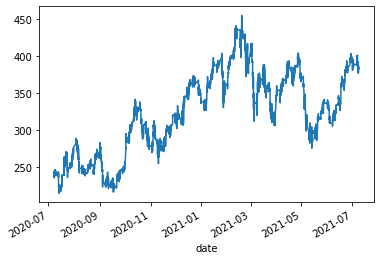

In [137]:
price_df['close'].plot()

In [138]:
# Datetime features

price_df['feature__dayofweek'] = price_df.index.dayofweek
price_df['feature__dayofweek'].value_counts()

2    20166
1    19859
3    19771
4    18434
0    18024
Name: feature__dayofweek, dtype: int64

In [139]:
daily_stats = pd.DataFrame()  # A

# A a dataframe to hold statistics by day

In [140]:
daily_stats['first_5_min_avg_close'] = price_df.groupby(price_df.index.date)['close'].apply(lambda x: x.head().mean())

In [141]:
daily_stats['last_5_min_avg_close'] = price_df.groupby(price_df.index.date)['close'].apply(lambda x: x.tail().mean())

In [142]:
daily_stats['feature__overnight_change_close'] = (daily_stats['first_5_min_avg_close'] - daily_stats['last_5_min_avg_close'].shift(1)) / daily_stats['last_5_min_avg_close'].shift(1)

In [143]:
daily_stats['feature__monthly_pct_change_close'] = daily_stats['first_5_min_avg_close'].pct_change(periods=31)

In [144]:
daily_stats

,first_5_min_avg_close,last_5_min_avg_close,feature__overnight_change_close,feature__monthly_pct_change_close
2020-07-08,237.975680,243.051000,NaN,NaN
2020-07-09,245.982160,245.631340,0.012060,NaN
2020-07-10,243.951000,240.884000,-0.006841,NaN
2020-07-13,241.795000,225.352000,0.003782,NaN
2020-07-14,223.668160,223.843000,-0.007472,NaN
...,...,...,...,...
2021-07-01,394.490320,386.239996,-0.001285,0.306463
2021-07-02,390.972504,389.064001,0.012253,0.342893
2021-07-06,388.284839,393.950006,-0.002003,0.289620
2021-07-07,399.926001,388.443561,0.015169,0.264159


In [145]:
price_df = price_df.merge(daily_stats, left_on=price_df.index.date, right_index=True)

price_df.head()

,key_0,close,volume,feature__dayofweek,first_5_min_avg_close,last_5_min_avg_close,feature__overnight_change_close,feature__monthly_pct_change_close
date,,,,,,,,
2020-07-08 06:30:00-07:00,2020-07-08,236.7300,46565.0,2,237.97568,243.051,NaN,NaN
2020-07-08 06:31:00-07:00,2020-07-08,237.3100,6603.0,2,237.97568,243.051,NaN,NaN
2020-07-08 06:32:00-07:00,2020-07-08,238.0800,15181.0,2,237.97568,243.051,NaN,NaN
2020-07-08 06:33:00-07:00,2020-07-08,238.4634,14304.0,2,237.97568,243.051,NaN,NaN
2020-07-08 06:34:00-07:00,2020-07-08,239.2950,11881.0,2,237.97568,243.051,NaN,NaN


<AxesSubplot:xlabel='date'>

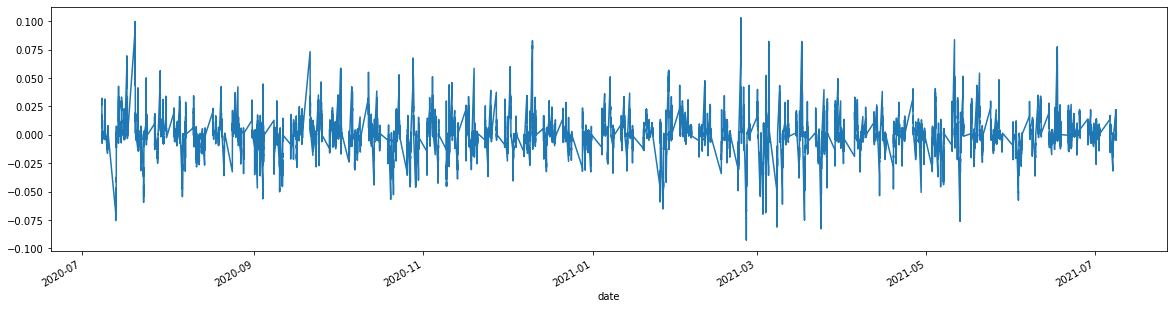

In [146]:
price_df['pct_change_eod'] = (price_df['last_5_min_avg_close'] - price_df['close']) / price_df['close']

price_df['pct_change_eod'].plot(figsize=(20,5))

In [147]:
price_df.dropna(inplace=True)

In [148]:
price_df.shape

(84182, 9)

In [149]:
price_df['stock_price_rose'] = price_df['pct_change_eod']  > 0

price_df['stock_price_rose'].value_counts()

True     43163
False    41019
Name: stock_price_rose, dtype: int64

In [150]:
%run ./Base.ipynb

In [154]:
from sklearn.pipeline import Pipeline  # A
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV


downsized_price_df = price_df[price_df.index.minute == 30]  # A
train_set, test_set = downsized_price_df[:'2021-05-31'], downsized_price_df['2021-06-01':]

clf = RandomForestClassifier(n_estimators=50, max_depth=None, random_state=0)
clf = DecisionTreeClassifier(max_depth=None)

ml_pipeline = Pipeline([  # C
    ('scale', StandardScaler()),
    ('classifier', clf)
])

params = {  # C
#     'classifier__n_estimators': [50, 100, 200, 500],
#     'classifier__bootstrap': [False, True]
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__min_samples_split': [2, 5, 10],
    
    'classifier__max_depth': [5, 10, None],
    'classifier__max_features': [None, 'auto', 'sqrt']
}

# A limit our data to only make trades after 8 when the market has been open for 1.5 hours and before noon (with at most an hour before close)

In [155]:
downsized_price_df['stock_price_rose'].value_counts(normalize=True)

True     0.508852
False    0.491148
Name: stock_price_rose, dtype: float64

In [156]:
downsized_price_df

,key_0,close,volume,feature__dayofweek,first_5_min_avg_close,last_5_min_avg_close,feature__overnight_change_close,feature__monthly_pct_change_close,pct_change_eod,stock_price_rose
date,,,,,,,,,,
2020-08-20 06:30:00-07:00,2020-08-20,248.079700,93916.0,3,247.897060,258.040000,-0.011133,0.041691,0.040150,True
2020-08-20 07:30:00-07:00,2020-08-20,254.720000,8895.0,3,247.897060,258.040000,-0.011133,0.041691,0.013034,True
2020-08-20 08:30:00-07:00,2020-08-20,255.670000,1423.0,3,247.897060,258.040000,-0.011133,0.041691,0.009270,True
2020-08-20 09:30:00-07:00,2020-08-20,255.090000,1465.0,3,247.897060,258.040000,-0.011133,0.041691,0.011565,True
2020-08-20 10:30:00-07:00,2020-08-20,257.480000,1047.0,3,247.897060,258.040000,-0.011133,0.041691,0.002175,True
...,...,...,...,...,...,...,...,...,...,...
2021-07-08 08:30:00-07:00,2021-07-08,379.869995,1258.0,3,380.841559,385.039496,-0.019570,0.207495,0.013609,True
2021-07-08 09:30:00-07:00,2021-07-08,382.859985,727.0,3,380.841559,385.039496,-0.019570,0.207495,0.005693,True
2021-07-08 10:30:00-07:00,2021-07-08,384.500000,1665.0,3,380.841559,385.039496,-0.019570,0.207495,0.001403,True


In [157]:
from sklearn.model_selection import TimeSeriesSplit  # A

tscv = TimeSeriesSplit(n_splits=2)  # A

# A This splitter 

In [158]:
print("Date-time features + Random Forest\n==========================")
best_model, test_preds, test_probas = advanced_grid_search(
    train_set.filter(regex='feature__'), train_set['stock_price_rose'],  # B
    test_set.filter(regex='feature__'), test_set['stock_price_rose'],   # B
    ml_pipeline, params, 
    cv=tscv, include_probas=True  # C
)


Date-time features + Random Forest
              precision    recall  f1-score   support

       False       0.47      0.74      0.57        81
        True       0.60      0.32      0.42       101

    accuracy                           0.51       182
   macro avg       0.53      0.53      0.49       182
weighted avg       0.54      0.51      0.48       182

Best params: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': 'auto', 'classifier__min_samples_split': 5}
Overall took 0.58 seconds


In [159]:
def test_threshold(df, predictions, probas, threshold):
    df['movement_correct_multiplier'] = (predictions == df['stock_price_rose']).map({True: 1, False: -1})
    df_over_threshold = df[probas >= threshold].copy()
    df_over_threshold['gain'] = df_over_threshold['movement_correct_multiplier'] * df_over_threshold['pct_change_eod'].abs()
    gains = df_over_threshold.sort_index().groupby(df_over_threshold.index.date).head(1)['gain']
    total_gains = gains.sum()
    std_gains = gains.std()
    print(f'Total Gains for threshold {threshold:.5f} is {total_gains:.3f} with std {std_gains:.3f}')
    return gains, total_gains, std_gains


In [160]:
def test_threshold(df, predictions):
    df['movement_correct_multiplier'] = (predictions == df['stock_price_rose']).map({True: 1, False: -1})
    df['gain'] = df['movement_correct_multiplier'] * df['pct_change_eod'].abs()
    bullish = df[predictions == True]
    bullish_gains = bullish.sort_index().groupby(bullish.index.date).head(1)['gain']
    bullish_gains.cumsum().plot(label='Bullish Only', legend=True)
    print(f'Total Gains for bullish is {bullish_gains.sum():.3f}')
    
    bearish = df[predictions == False]
    bearish_gains = bearish.sort_index().groupby(bearish.index.date).head(1)['gain']
    bearish_gains.cumsum().plot(label='Bearish Only', legend=True)
    print(f'Total Gains for bearish is {bearish_gains.sum():.3f}')
    
    gains = df.sort_index().groupby(df.index.date).head(1)['gain']
    gains.cumsum().plot(label='All Predictions', legend=True)
    print(f'Total Gains for all predictions is {gains.sum():.3f}')


Total Gains for bullish is 0.070
Total Gains for bearish is -0.057
Total Gains for all predictions is 0.013


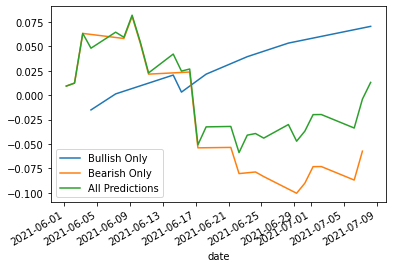

In [161]:
test_threshold(test_set.copy(), test_preds)

<AxesSubplot:xlabel='date'>

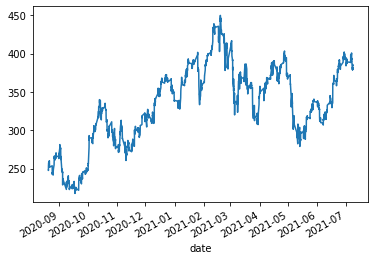

In [163]:
price_df['feature__rolling_close_mean_60'] = price_df['close'].rolling('60min').mean()

price_df['feature__rolling_close_mean_60'].plot()

In [164]:
price_df['feature__rolling_close_std_60'] = price_df['close'].rolling('60min').std()
price_df['feature__rolling_volume_mean_60'] = price_df['volume'].rolling('60min').mean()
price_df['feature__rolling_volume_std_60'] = price_df['volume'].rolling('60min').std()

price_df.dropna(inplace=True)

In [165]:
price_df.filter(regex='feature__').corrwith(price_df['pct_change_eod']).sort_values()

feature__monthly_pct_change_close   -0.051965
feature__rolling_close_mean_60      -0.033683
feature__dayofweek                  -0.025652
feature__rolling_close_std_60        0.009157
feature__overnight_change_close      0.011246
feature__rolling_volume_mean_60      0.011296
feature__rolling_volume_std_60       0.012812
dtype: float64

In [166]:

downsized_price_df = price_df[price_df.index.minute == 30]  # A
train_set, test_set = downsized_price_df[:'2021-05-31'], downsized_price_df['2021-06-01':]

print("Date-time features + Random Forest\n==========================")
best_model, test_preds, test_probas = advanced_grid_search(
    train_set.filter(regex='feature__'), train_set['stock_price_rose'],  # B
    test_set.filter(regex='feature__'), test_set['stock_price_rose'],   # B
    ml_pipeline, params,
    cv=tscv, include_probas=True  # C
)


Date-time features + Random Forest
              precision    recall  f1-score   support

       False       0.39      0.53      0.45        68
        True       0.48      0.34      0.40        87

    accuracy                           0.43       155
   macro avg       0.44      0.44      0.42       155
weighted avg       0.44      0.43      0.42       155

Best params: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 2}
Overall took 0.70 seconds


Total Gains for bullish is -0.034
Total Gains for bearish is 0.001
Total Gains for all predictions is -0.069


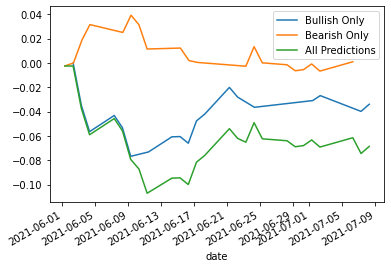

In [168]:
test_threshold(test_set.copy(), test_preds)

In [169]:
tweet_df = pd.read_csv(f"../data/{symbol}_tweets.csv", encoding='ISO-8859-1')

tweet_df.index = pd.to_datetime(tweet_df['date_tweeted'])
tweet_df.index = tweet_df.index.tz_convert('US/Pacific')
del tweet_df['date_tweeted']

tweet_df.sort_index(inplace=True)
tweet_df.dropna(inplace=True)

tweet_df = tweet_df['2020-07-08':'2021-07-08']


tweet_df.tail()

,text,tweet_unique_id,author_verified,num_followers
date_tweeted,,,,
2021-07-08 22:47:30-07:00,RT @HonestInvesting: Iâd be perfectly fine h...,1.413374e+18,False,148.0
2021-07-08 22:55:44-07:00,RT @HonestInvesting: Iâd be perfectly fine h...,1.413376e+18,False,53.0
2021-07-08 23:12:26-07:00,RT @HonestInvesting: Iâd be perfectly fine h...,1.413381e+18,False,696.0
2021-07-08 23:24:17-07:00,RT @reilly_mcadams: Names everyone talks about...,1.413383e+18,False,4.0
2021-07-08 23:30:29-07:00,RT @HonestInvesting: Iâd be perfectly fine h...,1.413385e+18,False,138.0


<AxesSubplot:xlabel='date_tweeted'>

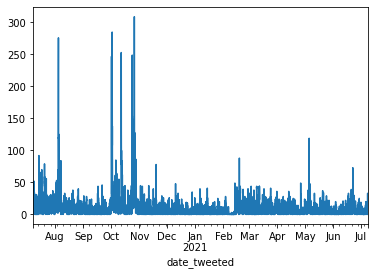

In [170]:
rolling_120_min_total_tweets = tweet_df.resample('1T')['tweet_unique_id'].count().rolling('120T').sum()

rolling_120_min_total_tweets.plot()

<AxesSubplot:xlabel='date_tweeted'>

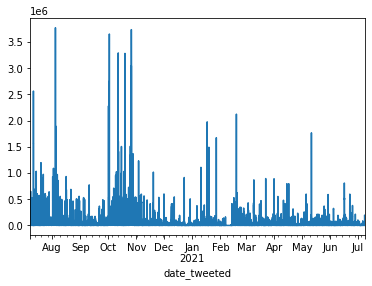

In [171]:
rolling_120_min_number_followers = tweet_df.resample('1T')['num_followers'].sum().rolling('120T').sum()

rolling_120_min_number_followers.plot()

In [172]:
twitter_stats = pd.DataFrame({
    'feature__rolling_120_min_total_tweets': rolling_120_min_total_tweets,
    'feature__rolling_120_min_number_followers': rolling_120_min_number_followers
})
twitter_stats.index = pd.to_datetime(twitter_stats.index)
twitter_stats.index = twitter_stats.index.tz_convert('US/Pacific')

twitter_stats.head()

,feature__rolling_120_min_total_tweets,feature__rolling_120_min_number_followers
date_tweeted,,
2020-07-08 00:45:00-07:00,1.0,31.0
2020-07-08 00:46:00-07:00,1.0,31.0
2020-07-08 00:47:00-07:00,1.0,31.0
2020-07-08 00:48:00-07:00,1.0,31.0
2020-07-08 00:49:00-07:00,1.0,31.0


In [173]:
price_df = price_df.merge(twitter_stats, left_index=True, right_index=True)

price_df.head()

,key_0,close,volume,feature__dayofweek,first_5_min_avg_close,last_5_min_avg_close,feature__overnight_change_close,feature__monthly_pct_change_close,pct_change_eod,stock_price_rose,feature__rolling_close_mean_60,feature__rolling_close_std_60,feature__rolling_volume_mean_60,feature__rolling_volume_std_60,feature__rolling_120_min_total_tweets,feature__rolling_120_min_number_followers
2020-08-20 06:31:00-07:00,2020-08-20,247.9500,8543.0,3,247.89706,258.04,-0.011133,0.041691,0.040694,True,248.014850,0.091712,51229.500000,60367.827230,14.0,17779.0
2020-08-20 06:32:00-07:00,2020-08-20,247.5000,14724.0,3,247.89706,258.04,-0.011133,0.041691,0.042586,True,247.843233,0.304241,39061.000000,47606.243908,14.0,17779.0
2020-08-20 06:33:00-07:00,2020-08-20,247.7306,18897.0,3,247.89706,258.04,-0.011133,0.041691,0.041615,True,247.815075,0.254715,34020.000000,40156.564802,14.0,17779.0
2020-08-20 06:34:00-07:00,2020-08-20,248.2250,17339.0,3,247.89706,258.04,-0.011133,0.041691,0.039541,True,247.897060,0.286823,30683.800000,35567.730103,14.0,17779.0
2020-08-20 06:35:00-07:00,2020-08-20,248.3100,35462.0,3,247.89706,258.04,-0.011133,0.041691,0.039185,True,247.965883,0.306975,31480.166667,31872.495023,14.0,17779.0


In [174]:
price_df.filter(regex='feature__').corrwith(price_df['pct_change_eod']).sort_values()

feature__monthly_pct_change_close           -0.051965
feature__rolling_close_mean_60              -0.033683
feature__dayofweek                          -0.025652
feature__rolling_close_std_60                0.009157
feature__overnight_change_close              0.011246
feature__rolling_volume_mean_60              0.011296
feature__rolling_volume_std_60               0.012812
feature__rolling_120_min_number_followers    0.019970
feature__rolling_120_min_total_tweets        0.022983
dtype: float64

In [175]:

downsized_price_df = price_df[price_df.index.minute == 30]  # A
train_set, test_set = downsized_price_df[:'2021-05-31'], downsized_price_df['2021-06-01':]


print("Twitter Features + Random Forest\n==========================")
best_model, test_preds, test_probas = advanced_grid_search(
    train_set.filter(regex='feature__'), train_set['stock_price_rose'],  # B
    test_set.filter(regex='feature__'), test_set['stock_price_rose'],   # B
    ml_pipeline, params, 
    cv=tscv, include_probas=True  # C
)


Twitter Features + Random Forest
              precision    recall  f1-score   support

       False       0.44      0.53      0.48        68
        True       0.57      0.48      0.52        87

    accuracy                           0.50       155
   macro avg       0.51      0.51      0.50       155
weighted avg       0.51      0.50      0.50       155

Best params: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 5}
Overall took 0.71 seconds


Total Gains for bullish is 0.013
Total Gains for bearish is -0.015
Total Gains for all predictions is 0.005


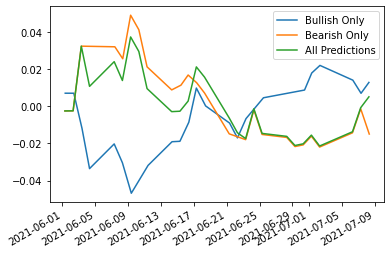

In [176]:
test_threshold(test_set.copy(), test_preds)

In [177]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

ml_pipeline = Pipeline([  
    ('scale', StandardScaler()),
    ('rfe', RFE(estimator=RandomForestClassifier(n_estimators=50, max_depth=None, random_state=0))),  # A
    ('classifier', clf)
])


print("Date-time features + Random Fores  + RFE\n==========================")
best_model, test_preds, test_probas = advanced_grid_search(
    train_set.filter(regex='feature__'), train_set['stock_price_rose'],  # B
    test_set.filter(regex='feature__'), test_set['stock_price_rose'],   # B
    ml_pipeline, params, 
    cv=tscv, include_probas=True  # C
)

Date-time features + Random Fores  + RFE
              precision    recall  f1-score   support

       False       0.47      0.81      0.60        68
        True       0.67      0.30      0.41        87

    accuracy                           0.52       155
   macro avg       0.57      0.55      0.51       155
weighted avg       0.58      0.52      0.49       155

Best params: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__min_samples_split': 5}
Overall took 47.90 seconds


In [181]:
list(zip(train_set.filter(regex='feature__').columns, best_model.named_steps['rfe'].ranking_))  # A

# A get  the ranking of features

[('feature__dayofweek', 6),
 ('feature__overnight_change_close', 1),
 ('feature__monthly_pct_change_close', 1),
 ('feature__rolling_close_mean_60', 1),
 ('feature__rolling_close_std_60', 1),
 ('feature__rolling_volume_mean_60', 4),
 ('feature__rolling_volume_std_60', 2),
 ('feature__rolling_120_min_total_tweets', 5),
 ('feature__rolling_120_min_number_followers', 3)]

Total Gains for bullish is 0.028
Total Gains for bearish is 0.028
Total Gains for all predictions is 0.081


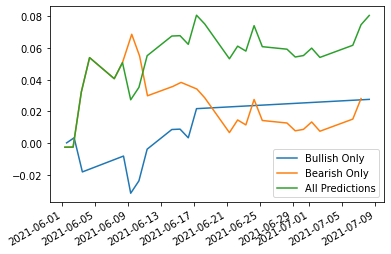

In [182]:
test_threshold(test_set.copy(), test_preds)

In [183]:
tweet_df  #  TODO sentiment

,text,tweet_unique_id,author_verified,num_followers
date_tweeted,,,,
2020-07-08 00:45:30-07:00,RT @MadMraket: $TWLO \n\nGood EX. to hold 8 wk...,1.280770e+18,False,31.0
2020-07-08 01:09:05-07:00,RT @ospuy: ãã®æ¹ãä¿æãã¦ããè¦è...,1.280776e+18,False,139.0
2020-07-08 01:51:33-07:00,RT @MadMraket: $TWLO \n\nGood EX. to hold 8 wk...,1.280787e+18,False,6273.0
2020-07-08 03:03:11-07:00,$TWLO ã¯èªç¤¾ã§ä½¿ããã¨ã«ãªãã$30ã...,1.280805e+18,False,1.0
2020-07-08 03:17:27-07:00,RT @ospuy: ãã®æ¹ãä¿æãã¦ããè¦è...,1.280808e+18,False,112.0
...,...,...,...,...
2021-07-08 22:47:30-07:00,RT @HonestInvesting: Iâd be perfectly fine h...,1.413374e+18,False,148.0
2021-07-08 22:55:44-07:00,RT @HonestInvesting: Iâd be perfectly fine h...,1.413376e+18,False,53.0
2021-07-08 23:12:26-07:00,RT @HonestInvesting: Iâd be perfectly fine h...,1.413381e+18,False,696.0


In [185]:
from sklearn.preprocessing import PolynomialFeatures

ml_pipeline = Pipeline([  
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures(2, include_bias=False)),
    ('rfe', RFE(estimator=RandomForestClassifier(n_estimators=50, max_depth=None, random_state=0))),  # A
    ('classifier', clf)
])

params['poly__degree'] = [2, 3]
params['poly__interaction_only'] = [False, True]


print("Date-time features + Random Forest + Poly + RFE\n==========================")
best_model, test_preds, test_probas = advanced_grid_search(
    train_set.filter(regex='feature__'), train_set['stock_price_rose'],  # B
    test_set.filter(regex='feature__'), test_set['stock_price_rose'],   # B
    ml_pipeline, params, 
    cv=tscv, include_probas=True  # C
)

Date-time features + Random Forest + Poly + RFE
              precision    recall  f1-score   support

       False       0.44      0.69      0.54        68
        True       0.56      0.31      0.40        87

    accuracy                           0.48       155
   macro avg       0.50      0.50      0.47       155
weighted avg       0.51      0.48      0.46       155

Best params: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__min_samples_split': 2, 'poly__degree': 2, 'poly__interaction_only': True}
Overall took 15471.62 seconds


Total Gains for bullish is 0.064
Total Gains for bearish is 0.070
Total Gains for all predictions is 0.121


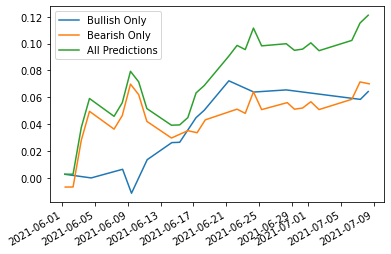

In [187]:
test_threshold(test_set.copy(), test_preds)

In [ ]:
# TODO baseline with just guessing bullish or bearish every day